
# Introduction

This *notebook* $^*$ demonstrates a unique application of Python to Earth and Atmospheric Science data: creating audio from data.

The dataset we are using is near-surface temperature from the NCEP/DOE Reanalysis 2, which can be thought of as observations (somewhat more accurately, it's a GFD model that effectively interpolates observations; take Prof. Kieu's Data Assimilation course if you want to learn more).

$^*$ A notebook in this context is a Jupyter notebook, which is a combination of text/media/equation *cells* (like this one) and cells that contain code, along with the outputs of the code.  You can think of it as a digital lab notebook.  We'll be using these on and off throughout the semester.  Any sort of Python code can go into the cells, and the organization is up to you.  I tend to group code into cells that do specific high-level things.  For example, the first cell below loads some 'external' python libraries that we'll need to simplify this data analysis.

NOTE: I'm italicizing new course vocabulary as I introduce it in this notebook.

In [1]:
""" Import libraries needed to read data & create sound """
import xarray as xr # for reading the air temperature data
import pandas as pd # for time/data manipulation
from IPython.lib.display import Audio # for playing sound in notebook

The above cell has several code elements that are important to point out because they'll be ubiquitous:

1. A *string* in the first line that doesn't actually do anything; it's just there to tell the viewer what I think the cell should do,
2. code that triggers the computer to do something (e.g., `import xarray as xr`), and
3. comments that don't do anything other than tell the viewer information I think would be useful (e.g., `# for reading the air temperature data`)

In order for the code in that cell to run, you will have to *execute* it.  We'll go over this in class.  Even once executed, you won't see any output from the above cell (at least you shouldn't...but who knows...computers are surprisingly non-deterministic sometimes), but that doesn't mean the cell didn't do anything.  In fact, that cell did a lot.  It loaded thousands of lines of python code that others have written for the purpose of making data analysis easier!

The next cell gets a bit more complicated, but don't worry too much about the details yet.  But can you tell what the cell is doing?  How?

In [2]:
""" Read in the data """

# set the year we want to download
year = 1983 
# set the URL for the NCEP/DOE Reanalysis 2 data file
url = f"https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis2/gaussian_grid/air.2m.gauss.{year}.nc"

# set the name of the file we want to download to
output_file = f"air.2m.gauss.{year}.nc"

# download the data file
# NOTE: the use of ! at the beginning of the line indicates that this is a shell command, not python code -- though it does use some python code.  How, why?
! curl --output {output_file} {url}

# open the dataset using xarray
temp_ds = xr.open_dataset(output_file, chunks = -1)

# show the dataset
temp_ds

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.8M  100 52.8M    0     0  23.1M      0  0:00:02  0:00:02 --:--:-- 23.1M


<xarray.Dataset>
Dimensions:  (level: 1, lat: 94, lon: 192, time: 1460)
Coordinates:
  * level    (level) float32 2.0
  * lat      (lat) float32 88.54 86.65 84.75 82.85 ... -84.75 -86.65 -88.54
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1983-01-01 ... 1983-12-31T18:00:00
Data variables:
    air      (time, level, lat, lon) float32 dask.array<chunksize=(1460, 1, 94, 192), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    title:          4x Daily NCEP/DOE Reanalysis 2
    comments:       Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)...
    platform:       Model
    source:         NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model
    institution:    National Centers for Environmental Prediction
    dataset_title:  NCEP-DOE AMIP-II Reanalysis
    References:     https://www.psl.noaa.gov/data/gridded/data.ncep.reanalysi...
    source_url:     http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/
    history:        created 2002/03 by RHS (netCDF2.3)\nConverted to chunked,...

Notice that the above cell had two outputs: one associated with the data download (from the line starting with `! curl --output...`) and one associated with the very last line of the cell `temp_ds`, which shows the contents of the `xarray` *object*, `temp_ds`, which represents the temperature dataset that I downloaded.

In the next cell, I extract a timeseries of temperature from a specific point (how can you tell where?).  It also does something that I commonly do in Jupyter notebooks: it plots the data just as a verification step that the *variable* `temp` contains the data that I expect.  This sort of 'check-as-you-go' coding style is critical for helping make sure your code is doing what you expect and also for help communicating what you're doing to other people (like your advisor, for example).

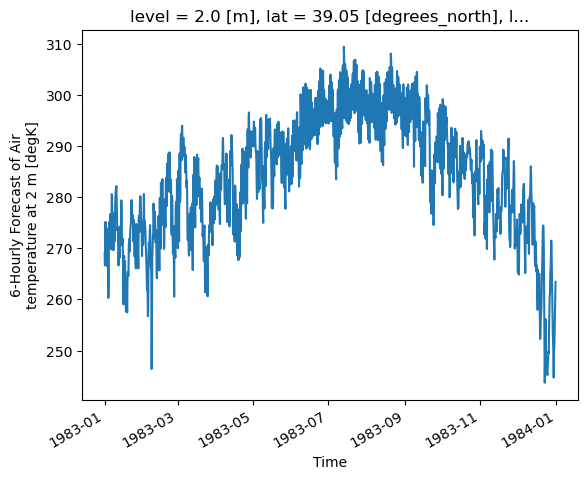

In [3]:
""" Extract data for a specific location"""
# here I'm using a point close to Bloomington, IN
lat = 39.1653
lon = -86.5264 + 360 # the longitude in the dataset is 0-360, not -180-180

# extract the data for the location
temp = temp_ds.air.sel(lat = lat, lon = lon, method = 'nearest').squeeze()

# plot the data
temp.plot();

What are your takeaways from the above plot?  Is it hard for you to think in Kelvin?  Can you add any code to convert to a temperature unit that you're more comfortable with?

## Making noise

This last cell converts our timeseries into a 10-second sound that we can play in the notebook (and that gets saved along with the notebook!).  Note below that there is a code line that technically spans five lines (the one starting with `times = pd.date_range(`).  If you put everything on one single line, would the result change?


In [4]:
""" Convert the data to sound """
# set the sampling rate
sampling_rate = 44100 # samples per second

# set the duration of the sound
duration = 10 # seconds

# create a series of evenly spaced times to match the sampling rate and duration
times = pd.date_range(
    start = temp.time[0].values,
    end = temp.time[-1].values,
    periods = sampling_rate * duration,
    )

# interpolate the data to the above times; this resamples
temp_resampled = temp.interp(time = times)

# extract the data as a numpy array, which is what the Audio() function needs
temp_np = temp_resampled.values

# center the data
temp_np = (temp_np - temp_np.mean())
# normalize the data to the range -1 to 1
temp_np = temp_np / temp_np.max()

# convert the data to sound that can be played in the notebook
Audio(temp_np, rate = sampling_rate)

## Summary

That's it - we've just done something pretty sophisticated without too many lines of code.  Now it's your turn. Can you customize this, for example, trying a different year, different location, or perhaps even introducing stereo (e.g., see [here](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#classes) for documentation of the `Audio` function)?